In [ ]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
import os 

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

llm=ChatGroq(model="llama-3.1-8b-instant")
llm.invoke('hello').content

In [ ]:
def multiply(a: int,b:int)-> int:
    """Multiply a and b 
    Args:
        a: first int 
        b: second int

    """

    return a * b

def add(a:int, b:int)->int:
    """ Adds a and b.

    Args:
    a: first int 
    b: second int 
    """

    return a + b

def divide(a:int,b:int)->float:
    """Divide a by bin
    
    Args:
        a: first int 
        b: second int
    
    """
    return a / b
    

In [ ]:
tools=[add,multiply,divide]
tools

In [ ]:
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

In [ ]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from IPython.display import display,Image




In [ ]:
sys_msg=SystemMessage(content="You are a helpful assistant tasked with performing arthmetic on a set of input ")

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [ ]:
builder=StateGraph(MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START,'assistant')
builder.add_conditional_edges(
    'assistant',
    #if the latest message(result) from assistant is a tool call -> tools_condition routes to tools
    #if the latest message(result) from assistant is not a tool call -> tools_condition routes to END
    
    tools_condition,
)
builder.add_edge('tools',"assistant")

memory=MemorySaver()

graph=builder.compile(interrupt_before=['assistant'],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [ ]:
thread={"configurable":{"thread_id":"123"}}
intial_input={"messages":HumanMessage(content="multiply 2 and 3 ")}

In [ ]:
for event in graph.stream(intial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

In [ ]:
state=graph.get_state(thread)
state.next

In [ ]:
state

In [ ]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

In [ ]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

In [ ]:
intial_input={'messages':HumanMessage(content="multiply 2 and 3")}

thread={'configurable':{"thread_id":'1'}}
for event in graph.stream(intial_input,thread,stream_mode='values'):
    event['messages'][-1].pretty_print()

In [ ]:
state=graph.get_state(thread)
state.next

In [ ]:
graph.update_state(thread,{"messages":[HumanMessage(content="No please multiply 15 and 6")]})

In [ ]:
new_state=graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()

In [ ]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

# Workflow will wait for the user input

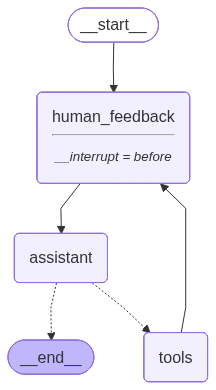

In [31]:
sys_message=HumanMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


def Human_feedback(state:MessagesState):
    pass

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder=StateGraph(MessagesState)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_node("human_feedback",Human_feedback)


builder.add_edge(START,'human_feedback')
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    #if the latest message(result) from assistant is a tool call -> tools_condition routes to tools
    #if the latest message(result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge('tools',"human_feedback")

memory=MemorySaver()
graph=builder.compile(interrupt_before=['human_feedback'],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [32]:
intial_input={"messages":"multiply 2 and 3"}

thread={"configurable":{"thread_id":"5"}}

for event in graph.stream(intial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

user_input=input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3
================================ Human Message =================================

multiply 5 and 6 instead of 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (ptvtfw21g)
 Call ID: ptvtfw21g
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30
